<a href="https://colab.research.google.com/github/svensundell/TDA384/blob/master/JUGE_SAINI_neural_style_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Neural Transfer Using PyTorch


**Author**: [Alexis Jacq](https://alexis-jacq.github.io)
 
**Edited by**: [Winston Herring](https://github.com/winston6)

## Introduction

This tutorial explains how to implement the [Neural-Style algorithm](https://arxiv.org/abs/1508.06576)_
developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.
Neural-Style, or Neural-Transfer, allows you to take an image and
reproduce it with a new artistic style. The algorithm takes three images,
an input image, a content-image, and a style-image, and changes the input 
to resemble the content of the content-image and the artistic style of the style-image.

 
.. figure:: /_static/img/neural-style/neuralstyle.png
   :alt: content1


## Underlying Principle

The principle is simple: we define two distances, one for the content
($D_C$) and one for the style ($D_S$). $D_C$ measures how different the content
is between two images while $D_S$ measures how different the style is
between two images. Then, we take a third image, the input, and
transform it to minimize both its content-distance with the
content-image and its style-distance with the style-image. Now we can
import the necessary packages and begin the neural transfer.

## Importing Packages and Selecting a Device
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pre-trained models)
-  ``copy`` (to deep copy the models; system package)



In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device. 



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the Images

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when
transformed into torch tensors, their values are converted to be between
0 and 1. The images also need to be resized to have the same dimensions.
An important detail to note is that neural networks from the
torch library are trained with tensor values ranging from 0 to 1. If you
try to feed the networks with 0 to 255 tensor images, then the activated
feature maps will be unable to sense the intended content and style.
However, pre-trained networks from the Caffe library are trained with 0
to 255 tensor images. 


.. Note::
    Here are links to download the images required to run the tutorial:
    [picasso.jpg](https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg)_ and
    [dancing.jpg](https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg)_.
    Download these two images and add them to a directory
    with name ``images`` in your current working directory.



In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./picasso.jpg")
content_img = image_loader("./dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Now, let's create a function that displays an image by reconverting a 
copy of it to PIL format and displaying the copy using 
``plt.imshow``. We will try displaying the content and style images 
to ensure they were imported correctly.



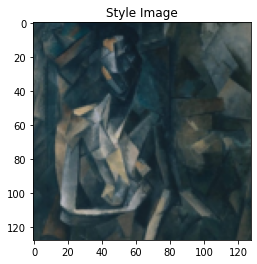

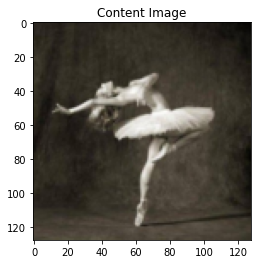

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Functions
Content Loss
~~~~~~~~~~~~

The content loss is a function that represents a weighted version of the
content distance for an individual layer. The function takes the feature
maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the
weighted content distance $w_{CL}.D_C^L(X,C)$ between the image $X$ and the
content image $C$. The feature maps of the content image($F_{CL}$) must be
known by the function in order to calculate the content distance. We
implement this function as a torch module with a constructor that takes
$F_{CL}$ as an input. The distance $\|F_{XL} - F_{CL}\|^2$ is the mean square error
between the two sets of feature maps, and can be computed using ``nn.MSELoss``.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image the content losses will be
computed at the desired layers and because of auto grad, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a ``forward`` method that computes the content
loss and then returns the layer’s input. The computed loss is saved as a
parameter of the module.




In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

.. Note::
   **Important detail**: although this module is named ``ContentLoss``, it
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss function, you have to create a PyTorch autograd function 
   to recompute/implement the gradient manually in the ``backward``
   method.



### Style Loss

The style loss module is implemented similarly to the content loss
module. It will act as a transparent layer in a
network that computes the style loss of that layer. In order to
calculate the style loss, we need to compute the gram matrix $G_{XL}$. A gram
matrix is the result of multiplying a given matrix by its transposed
matrix. In this application the given matrix is a reshaped version of
the feature maps $F_{XL}$ of a layer $L$. $F_{XL}$ is reshaped to form $\hat{F}_{XL}$, a $K$\ x\ $N$
matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is the
length of any vectorized feature map $F_{XL}^k$. For example, the first line
of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.

Finally, the gram matrix must be normalized by dividing each element by
the total number of elements in the matrix. This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$ dimension yield
larger values in the Gram matrix. These larger values will cause the
first layers (before pooling layers) to have a larger impact during the
gradient descent. Style features tend to be in the deeper layers of the
network so this normalization step is crucial.




In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square
error between $G_{XL}$ and $G_{SL}$.




In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing the Model

Now we need to import a pre-trained neural network. We will use a 19
layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: ``features`` (containing convolution and pooling layers),
and ``classifier`` (containing fully connected layers). We will use the
``features`` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using ``.eval()``.




In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




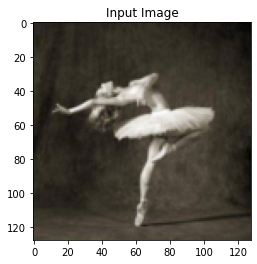

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

## Gradient Descent

As Leon Gatys, the author of the algorithm, suggested [here](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq)_, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimise the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.




Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 98.429321 Content Loss: 17.730108

run [100]:
Style Loss : 23.810619 Content Loss: 16.175709

run [150]:
Style Loss : 9.708190 Content Loss: 14.191810

run [200]:
Style Loss : 5.100715 Content Loss: 12.337824

run [250]:
Style Loss : 3.338744 Content Loss: 10.874058

run [300]:
Style Loss : 2.636498 Content Loss: 9.818277



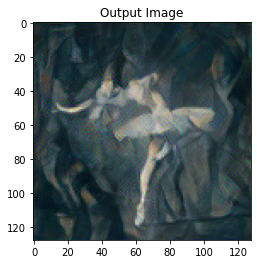

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# OUR ADDITIONNAL WORK: TRANSFERRING IMAGE STYLE TO VIDEO


# Exemple 1: Transferring the style of an image to a video for which the main content is easily detectable (here the woman dancing at the center)

To transfer the image style to the video, we will do style transfer with every frame of the video, the frame of the video beeing the content

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf

Downloading the video and cutting it into frame:
(you can download the new picasso style and the video right here: 

In [ ]:
# Read the video from specified path
cam = cv2.VideoCapture("./dancingcontent.mp4")
try:
# creating a folder named data
    if not os.path.exists('data2'):
        os.makedirs('data2')
# if not created then raise error
except OSError:
    print('Error: Creating directory of data')

# frame
currentframe = 0

while(True):

#reading from frame
    ret,frame = cam.read()

    if ret:
        # if video is still left continue creating images
        name = './data2/frame' + str(currentframe) + '.jpg'
        print('Creating...' + name)

        # writing the extracted images
        cv2.imwrite(name, frame)
# increasing counter so that it will
# show how many frames are created
        currentframe += 1
    else:
        break

# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

Creating..../data2/frame0.jpg
Creating..../data2/frame1.jpg
Creating..../data2/frame2.jpg
Creating..../data2/frame3.jpg
Creating..../data2/frame4.jpg
Creating..../data2/frame5.jpg
Creating..../data2/frame6.jpg
Creating..../data2/frame7.jpg
Creating..../data2/frame8.jpg
Creating..../data2/frame9.jpg
Creating..../data2/frame10.jpg
Creating..../data2/frame11.jpg
Creating..../data2/frame12.jpg
Creating..../data2/frame13.jpg
Creating..../data2/frame14.jpg
Creating..../data2/frame15.jpg
Creating..../data2/frame16.jpg
Creating..../data2/frame17.jpg
Creating..../data2/frame18.jpg
Creating..../data2/frame19.jpg
Creating..../data2/frame20.jpg
Creating..../data2/frame21.jpg
Creating..../data2/frame22.jpg
Creating..../data2/frame23.jpg
Creating..../data2/frame24.jpg
Creating..../data2/frame25.jpg
Creating..../data2/frame26.jpg
Creating..../data2/frame27.jpg
Creating..../data2/frame28.jpg
Creating..../data2/frame29.jpg
Creating..../data2/frame30.jpg
Creating..../data2/frame31.jpg
Creating..../data2

In [ ]:
from torchvision.utils import save_image
import glob

## Exemple1 with white noise as input img


At first we will do neural style transfer for each frame taking a noisy input as the input image on which we will perform gradient descent



Now we will import the style and one content image to do an example of one frame step. The original PIL images have values between 0 and 255, but when
transformed into torch tensors, their values are converted to be between
0 and 1. The images also need to be resized to have the same dimensions.
An important detail to note is that neural networks from the
torch library are trained with tensor values ranging from 0 to 1. If you
try to feed the networks with 0 to 255 tensor images, then the activated
feature maps will be unable to sense the intended content and style.
However, pre-trained networks from the Caffe library are trained with 0
to 255 tensor images. 





In [ ]:
style_img_2 = image_loader("./picasso_style.jpg")
content_2=image_loader("./data2/frame0.jpg")


print(style_img_2.size())
print(content_2.size())

torch.Size([1, 3, 128, 185])
torch.Size([1, 3, 128, 242])


torch.Size([1, 3, 128, 185])
torch.Size([1, 3, 128, 185])


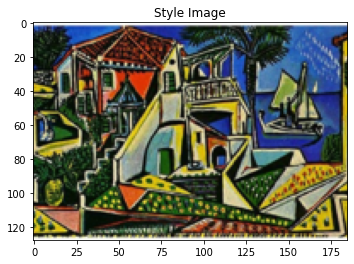

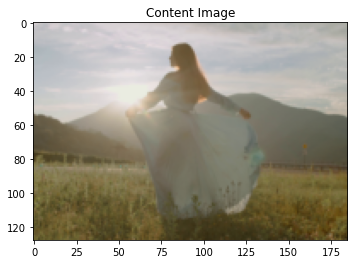

In [ ]:
content_img_2=content_2[:,:,:,28:213]
print(style_img_2.size())
print(content_img_2.size())

assert style_img_2.size() == content_img_2.size(), \
    "we need to import style and content images of the same size"


plt.figure()
imshow(style_img_2, title='Style Image')

plt.figure()
imshow(content_img_2, title='Content Image')

Noisy input image for gradient descent:

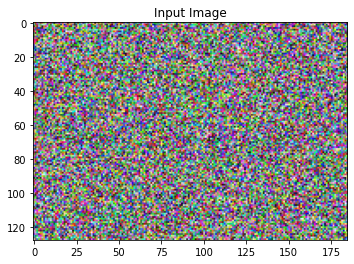

In [ ]:
input_img_2 = torch.randn(content_img_2.data.size(), device=device)
#input_img_2 = content_img_2.clone()
# add the original input image to the figure:
plt.figure()
imshow(input_img_2, title='Input Image')

Performing style transfer for the first frame:

Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 9.738631 Content Loss: 59.274464

run [100]:
Style Loss : 17.830976 Content Loss: 49.957008

run [150]:
Style Loss : 8.885656 Content Loss: 48.432362

run [200]:
Style Loss : 7.124188 Content Loss: 49.418552

run [250]:
Style Loss : 7.321921 Content Loss: 45.812649

run [300]:
Style Loss : 7.690808 Content Loss: 46.078541



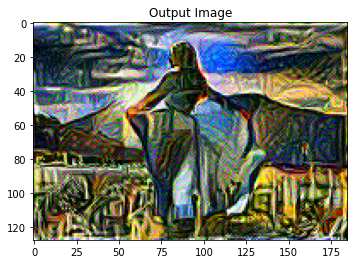

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_2, style_img_2, input_img_2,style_weight=5000,num_steps=300)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
try:
# creating a folder named data
    if not os.path.exists('results_dancing_white_noise'):
        os.makedirs('results_dancing_white_noise')
# if not created then raise error
except OSError:
    print('Error: Creating directory of data')

We will now repeat this for every frame of the video

In [ ]:
for i in range(78):
  actual_content=image_loader("./data2/frame"+str(i)+".jpg")
  actual_content=actual_content[:,:,:,28:213]
  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            actual_content, style_img_2, input_img_2,style_weight=5000,num_steps=300)
  name = './results_dancing_white_noise/frame' + str(i) + '.jpg'
      

  
  save_image(output, name)
  


Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 6.091371 Content Loss: 48.182770

run [100]:
Style Loss : 8.980567 Content Loss: 50.113747

run [150]:
Style Loss : 6.436038 Content Loss: 47.405586

run [200]:
Style Loss : 6.818713 Content Loss: 46.370472

run [250]:
Style Loss : 5.881828 Content Loss: 46.674171

run [300]:
Style Loss : 6.314143 Content Loss: 46.649754

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5.701936 Content Loss: 45.504341

run [100]:
Style Loss : 5.861894 Content Loss: 44.982395

run [150]:
Style Loss : 6.611312 Content Loss: 50.117729

run [200]:
Style Loss : 6.214972 Content Loss: 46.029945

run [250]:
Style Loss : 71.837463 Content Loss: 68.677017

run [300]:
Style Loss : 10.234344 Content Loss: 58.110676

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.802967 Content Loss: 49.736889

run [100]:
Style Loss : 6.407948 Content Loss: 47.390759

run [150]:
Style Loss : 6.053730 Content Loss: 47.786243

run [200]:
Style Los

In [ ]:
import glob


Finally we merge all the transformed frame into one video and save it

In [ ]:

img_array = []
for i in range(78):
    filename = "./results_dancing_white_noise/frame"+str(i)+".jpg"
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('dancing_video_white_noise.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

The transformed video can be download here:

## Exemple1 with last output as input img


With the last result, we saw that the style transformation was not consistent in the video, and that sometimes there were some "glitch" when the frame is still a noisy picture like the noisy input. This can happen when the style loss computed is to high to modify the tensor values into a value bounded between 0 and 1.

Then what we will try is to take the previous modified frame as the input image on which we perform gradient descent for the style transfer of the next frame

Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 11.298916 Content Loss: 58.590317

run [100]:
Style Loss : 9.027704 Content Loss: 50.361183

run [150]:
Style Loss : 7.736910 Content Loss: 52.229656

run [200]:
Style Loss : 5.968270 Content Loss: 48.388744

run [250]:
Style Loss : 6.141536 Content Loss: 46.512802

run [300]:
Style Loss : 6.531657 Content Loss: 50.733315



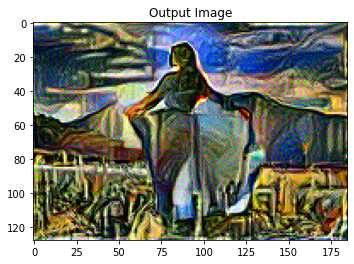

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_2, style_img_2, input_img_2,style_weight=5000,num_steps=300)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
try:
# creating a folder named data
    if not os.path.exists('last_output'):
        os.makedirs('last_output')
# if not created then raise error
except OSError:
    print('Error: Creating directory of data')

Saving the previous modified frame as the input image we will use for the next gradient descent:

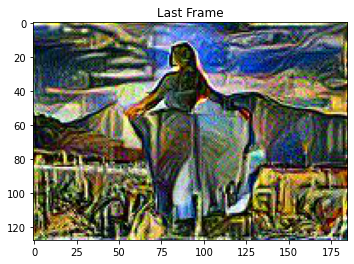

In [ ]:
save_image(output,"./last_output/last_frame.jpg")
input_img_3=image_loader("./last_output/last_frame.jpg")
plt.figure()
imshow(input_img_3, title='Last Frame')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
print(style_img_2.size())
print(content_img_2.size())
print(input_img_3.size())

torch.Size([1, 3, 128, 185])
torch.Size([1, 3, 128, 185])
torch.Size([1, 3, 128, 185])


One example of result when we take the previous modified frame as the input image:

Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 5.642012 Content Loss: 45.702850

run [100]:
Style Loss : 5.773756 Content Loss: 44.911758



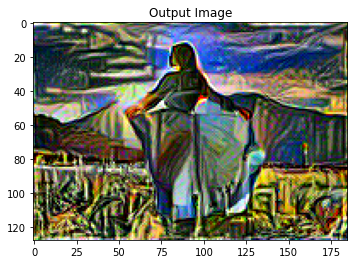

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_2, style_img_2, input_img_3,style_weight=5000,num_steps=100)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
try:
# creating a folder named data
    if not os.path.exists('results_dancing_last_frame'):
        os.makedirs('results_dancing_last_frame')
# if not created then raise error
except OSError:
    print('Error: Creating directory of data')

In [ ]:
input_img_2 = torch.randn(content_img_2.data.size(), device=device)

We now repeat this step for every frame of the video

In [ ]:
for i in range(78):
  if i==0:
    actual_content=image_loader("./data2/frame"+str(i)+".jpg")
    actual_content=actual_content[:,:,:,28:213]
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            actual_content, style_img_2, input_img_2,style_weight=5000,num_steps=300)
    name = './results_dancing_last_frame/frame' + str(i) + '.jpg'
  else:
    actual_content=image_loader("./data2/frame"+str(i)+".jpg")
    actual_content=actual_content[:,:,:,28:213]

    save_image(output,"./last_output/last_frame.jpg")
    input_img_3=image_loader("./last_output/last_frame.jpg")
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            actual_content, style_img_2, input_img_2,style_weight=5000,num_steps=100)
    name = './results_dancing_last_frame/frame' + str(i) + '.jpg'
  
  save_image(output, name)

Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 10.080631 Content Loss: 59.143890

run [100]:
Style Loss : 6.499499 Content Loss: 51.974266

run [150]:
Style Loss : 6.257887 Content Loss: 49.021103

run [200]:
Style Loss : 6.035400 Content Loss: 47.356258

run [250]:
Style Loss : 6.492753 Content Loss: 48.176857

run [300]:
Style Loss : 7.280550 Content Loss: 51.279057

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5.708053 Content Loss: 46.483570

run [100]:
Style Loss : 6.933713 Content Loss: 44.538979

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5.994935 Content Loss: 45.836063

run [100]:
Style Loss : 7.486611 Content Loss: 43.902008

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5.700116 Content Loss: 45.118206

run [100]:
Style Loss : 5.910468 Content Loss: 44.077309

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5.598971 Content Loss: 42.335342

run [100]:
Style Loss : 5.760697 Content 

Finally we merge all the modified frame into a video and we save it

In [ ]:
img_array = []
for i in range(78):
    filename = "./results_dancing_last_frame/frame"+str(i)+".jpg"
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('dancing_video_last_frame.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

The final video can be download here

We can notice that for this video, the style transfer is way more consistent than when we took a noisy image as the input image. 

# Exemple2

Finally, for bonus content, we will try this experiment again on a video where the main content of the video is not easily detectable

In [ ]:
# Read the video from specified path
cam = cv2.VideoCapture("./kawhi.mp4")
try:
# creating a folder named data
    if not os.path.exists('data'):
        os.makedirs('data')
# if not created then raise error
except OSError:
    print('Error: Creating directory of data')

# frame
currentframe = 0

while(True):

#reading from frame
    ret,frame = cam.read()

    if ret:
        # if video is still left continue creating images
        name = './data/frame' + str(currentframe) + '.jpg'
        print('Creating...' + name)

        # writing the extracted images
        cv2.imwrite(name, frame)
# increasing counter so that it will
# show how many frames are created
        currentframe += 1
    else:
        break

# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame17.jpg
Creating..../data/frame18.jpg
Creating..../data/frame19.jpg
Creating..../data/frame20.jpg
Creating..../data/frame21.jpg
Creating..../data/frame22.jpg
Creating..../data/frame23.jpg
Creating..../data/frame24.jpg
Creating..../data/frame25.jpg
Creating..../data/frame26.jpg
Creating..../data/frame27.jpg
Creating..../data/frame28.jpg
Creating..../data/frame29.jpg
Creating..../data/frame30.jpg
Creating..../data/frame31.jpg
Creating..../data/frame32.jpg
Creating..../data/fr



## Exemple 2 with white noise given as the input img


In [ ]:
content= image_loader("./data/frame0.jpg")
style_img = image_loader("./picasso.jpg")

print(style_img.size())
print(content.size())



torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 227])


In [ ]:
content_img=content[:,:,:,50:178]
print(style_img.size())
print(content_img.size())

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


In [ ]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

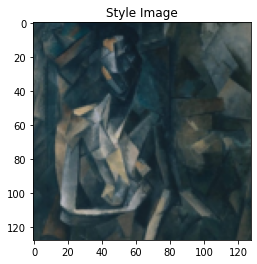

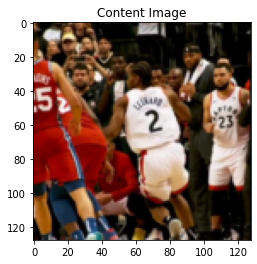

In [ ]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In the next cell we perform a style transfer for the first frame, note that we can't transfer the style too much, otherwise the result ouput is not clear, maybe because the main content (the player in the middle) is not easaly extractable from the rest of the frame:

Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 2.891479 Content Loss: 37.444092

run [100]:
Style Loss : 2.848424 Content Loss: 29.159611

run [150]:
Style Loss : 2.506227 Content Loss: 25.695480

run [200]:
Style Loss : 2.405550 Content Loss: 23.773033

run [250]:
Style Loss : 2.304928 Content Loss: 22.811762

run [300]:
Style Loss : 2.241030 Content Loss: 22.193815



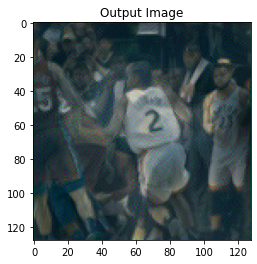

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,style_weight=200000,num_steps=300)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
try:
# creating a folder named data
    if not os.path.exists('results_white_noise'):
        os.makedirs('results_white_noise')
# if not created then raise error
except OSError:
    print('Error: Creating directory of data')


In [ ]:
from torchvision.utils import save_image

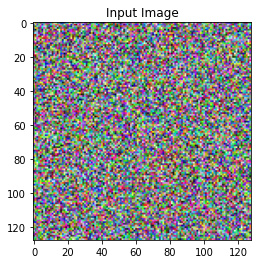

In [ ]:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
for i in range(118):
  actual_content=image_loader("./data/frame"+str(i)+".jpg")
  actual_content=actual_content[:,:,:,50:178]
  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            actual_content, style_img, input_img,style_weight=200000,num_steps=300)
  name = './results_white_noise/frame' + str(i) + '.jpg'
      

  
  save_image(output, name)
  



Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 29.230461 Content Loss: 49.478397

run [100]:
Style Loss : 12.393723 Content Loss: 34.577354

run [150]:
Style Loss : 6.460489 Content Loss: 28.155403

run [200]:
Style Loss : 3.681013 Content Loss: 24.786039

run [250]:
Style Loss : 2.809856 Content Loss: 23.281942

run [300]:
Style Loss : 2.496765 Content Loss: 22.460640

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.450897 Content Loss: 22.368778

run [100]:
Style Loss : 2.347094 Content Loss: 21.796265

run [150]:
Style Loss : 2.276570 Content Loss: 21.475840

run [200]:
Style Loss : 2.216280 Content Loss: 21.291655

run [250]:
Style Loss : 2.178869 Content Loss: 21.201691

run [300]:
Style Loss : 2.158008 Content Loss: 21.138729

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.237630 Content Loss: 21.877979

run [100]:
Style Loss : 2.184298 Content Loss: 21.460926

run [150]:
Style Loss : 2.162787 Content Loss: 21.320179

run [200]:
Style Los

In [ ]:
import glob


In [ ]:

img_array = []
for i in range(118):
    filename = "./results_white_noise/frame"+str(i)+".jpg"
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

The video obtained can be download here:

We see that the color style of the style image is well transferred, however when it comes to other characteristics of the style image, it's not really well transferred, mostly because we choose to not transfer the style too much (explaination a few cells before)

# Exemple 2 with previous modified frame given as the input img


We will now try to take the previous modified frame as the input image on which we perform gradient descent for the style transfer of the next frame to try to transfer more of the style (we use a bigger "style weight")

In [ ]:
content= image_loader("./data/frame0.jpg")
style_img = image_loader("./picasso.jpg")

print(style_img.size())
print(content.size())



torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 227])


In [ ]:
content_img=content[:,:,:,50:178]
print(style_img.size())
print(content_img.size())

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


In [ ]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

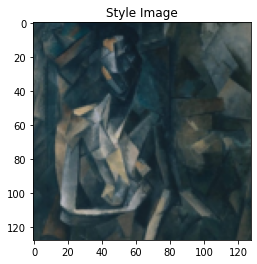

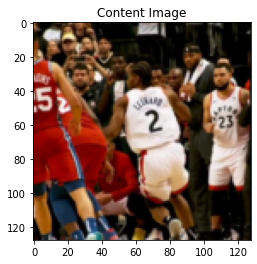

In [ ]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

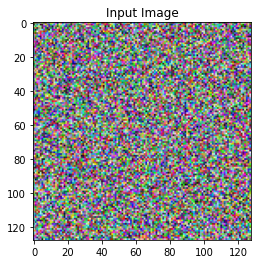

In [ ]:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 124.194382 Content Loss: 63.792816

run [100]:
Style Loss : 47.978420 Content Loss: 54.477783

run [150]:
Style Loss : 20.710152 Content Loss: 46.461624

run [200]:
Style Loss : 9.327696 Content Loss: 40.838402

run [250]:
Style Loss : 6.071926 Content Loss: 36.693813

run [300]:
Style Loss : 5.051098 Content Loss: 33.485161



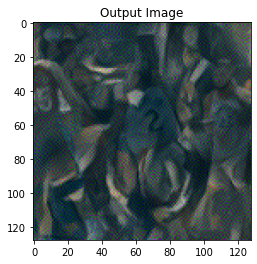

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,style_weight=1000000,num_steps=300)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
try:
# creating a folder named data
    if not os.path.exists('last_output'):
        os.makedirs('last_output')
# if not created then raise error
except OSError:
    print('Error: Creating directory of data')

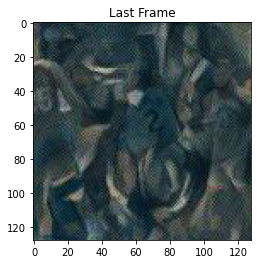

In [ ]:
save_image(output,"./last_output/last_frame.jpg")
input_img_4=image_loader("./last_output/last_frame.jpg")
plt.figure()
imshow(input_img_4, title='Last Frame')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
print(style_img.size())
print(content_img.size())
print(input_img_4.size())

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


In [ ]:
try:
# creating a folder named data
    if not os.path.exists('results_last_basket_output'):
        os.makedirs('results_last_basket_output')
# if not created then raise error
except OSError:
    print('Error: Creating directory of data')


In [ ]:
for i in range(118):
  actual_content=image_loader("./data/frame"+str(i)+".jpg")
  actual_content=actual_content[:,:,:,50:178]
  if i==0:
    
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            actual_content, style_img, input_img,style_weight=200000,num_steps=300)
    name = './results_last_basket_output/frame' + str(i) + '.jpg'
  else:
    save_image(output,"./last_output/last_frame.jpg")
    input_img_4=image_loader("./last_output/last_frame.jpg")
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            actual_content, style_img, input_img_4,style_weight=200000,num_steps=100)
    name = './results_last_basket_output/frame' + str(i) + '.jpg'
  
  save_image(output, name)

Building the style transfer model..


<ipython-input-10-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 2.127001 Content Loss: 21.213032

run [100]:
Style Loss : 2.124540 Content Loss: 21.206211

run [150]:
Style Loss : 2.121624 Content Loss: 21.199255

run [200]:
Style Loss : 2.117289 Content Loss: 21.193840

run [250]:
Style Loss : 2.115082 Content Loss: 21.186825

run [300]:
Style Loss : 2.111695 Content Loss: 21.180397

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.365731 Content Loss: 23.042927

run [100]:
Style Loss : 2.156162 Content Loss: 21.711687

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.322040 Content Loss: 23.232370

run [100]:
Style Loss : 2.171713 Content Loss: 21.944052

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.273441 Content Loss: 23.774910

run [100]:
Style Loss : 2.163035 Content Loss: 22.231033

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.356464 Content Loss: 24.216351

run [100]:
Style Loss : 2.197193 Content L

In [ ]:
img_array = []
for i in range(118):
    filename = "./results_last_basket_output/frame"+str(i)+".jpg"
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('basket_last_output_vide.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

The video can be download here:

We can clearly see some results (taking into account that we increased a lot the style weight)